# Assignment 2
Date: 01/18/2026


You work for a university that wants to make searching for research articles easier.  The plan is to train a machine learning model that tags articles with one of several predefined categories, that will be used as metadata by the university's search engine. Graciously, the university has provided you with the necessary data.

The university wants the process of tagging any new research articles to be an overnight process, as the new articles do not need to be made immediately available to users. When searching, users have a preference for not being shown articles that are irrelevant to their search.

**Notes:**

- Code for reading the data is listed below.
- The data comes with "title" and "abstract" fields. You may use either (or both) for your modeling.
- The "subject" field is your target.
- Preprocess your text accordingly (if you plan to try a BOW model, what kind of preprocessing makes sense?)
- Try at least 3 models (non-deep learning only).
- Your submission must include some kind of output that evaluates the chosen models so the grader can understand your model of choice.
- Submit your assignment as a .ipynb and a .html or .pdf file

**Answer the following questions:**

- What kind of models did you try and why?
- How did you evaluate the model and which metric do you think is most important? **Hint: Read the second paragraph introducing the assignment.**
- How did you investigate misclassifications?
- Were the misclassifications understandable (genuinely difficult examples) or were they blatant errors? Provide a few examples.

## Environment Setup and Data Load

In [1]:
import sys

import spacy
import multiprocessing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import (
    CountVectorizer,
    HashingVectorizer,
    TfidfVectorizer,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
)
RANDOM_STATE = 0
SPACY_MODEL = "en_core_web_md"

url = "https://storage.googleapis.com/adsp-nlp-open/data/elsevier-oa-cc-by/abstracts.json"
data_df = pd.read_json(url, orient="records")

In [2]:
data_df.shape

(38686, 4)

In [3]:
data_df.head()

,doc_id,title,abstract,subject
0,S0960076016300644,Sterols and oxysterols in plasma from Smith-Le...,Smith-Lemli-Opitz syndrome (SLOS) is a severe ...,phys_sci
1,S1471492219301369,The Uncertainty Surrounding the Burden of Post...,Post-acute consequences currently form a signi...,healh_sci
2,S2405580815000801,Low-mass molecular dynamics simulation for con...,"It has been reported recently that classical, ...",phys_sci
3,S0142961216305853,Modulation of the molecular arrangement in art...,The transfer of material from phospholipid-coa...,engi_tech
4,S0003682X1500242X,Validation of the blocked force method for var...,Vibro-acoustic source characterization is an e...,phys_sci


In [4]:
CATEGORIES = data_df['subject'].unique()
CATEGORIES

array(['phys_sci', 'healh_sci', 'engi_tech', 'life_sci', 'soc_sci'],
      dtype=object)

In [5]:
## simple clearning step
data_df["abstract_clean_light"] = (
    data_df["abstract"]
    .str.replace(r"(\s)+", " ", regex=True, )
    .str.replace(r"([^a-zA-Z0-9])\1+", r"\1", regex=True) # replacing repeat occurances of nonalphanumeric with just one occurance. the "\1" is called a back reference in regex
)

In [6]:
data_df.sample(5)

,doc_id,title,abstract,subject,abstract_clean_light
777,S221501611730016X,Treatment of sugar processing industry effluen...,Sugar industry is an oldest accommodates indus...,phys_sci,Sugar industry is an oldest accommodates indus...
2086,S0006291X1830490X,Regulation of keratin 5/14 intermediate filame...,"We previously reported that vimentin, GFAP, an...",phys_sci,"We previously reported that vimentin, GFAP, an..."
37575,S1570963914002623,Functional and dysfunctional conformers of hum...,Neuroserpin (NS) is a serine protease inhibito...,phys_sci,Neuroserpin (NS) is a serine protease inhibito...
30840,S1369526616301054,Modelling impacts of climate change on arable ...,"Combining climate change, crop growth and crop...",life_sci,"Combining climate change, crop growth and crop..."
3131,S0141933119300250,Understanding multidimensional verification: W...,Advancements in electronic systems’ design hav...,engi_tech,Advancements in electronic systems’ design hav...


In [9]:
def clean_text(corpus, spacy_pipeline, n_proc=2, batch_size=1000):
    """
    Cleans a sequence of text by applying some simple processing techniques.

    Args:
        corpus (Iterable): a sequence of text to be processed
        spacy_pipeline: the Spacy pipeline object for processing text
        n_proc (int): the number of processors to use for parallel processing
        batch_size (int): the number of texts to process in a single batch

    Returns:
        clean_sequence (list): a cleaned version of the original text
    """
    # container to store cleaned documents
    corpus_clean = []

    for doc in spacy_pipeline.pipe(
        corpus,
        disable=["ner"],
        n_process=n_proc,
        batch_size=batch_size
    ):

        # container for cleaned document tokens
        doc_tokens = [
            token.lemma_.lower().strip()
            for token in doc
            if not any([token.is_stop, token.is_punct, token.is_space])
        ]

        # recombining tokens into a string
        clean_doc = " ".join(doc_tokens)
        
        corpus_clean.append(clean_doc)

    return corpus_clean


def ratio_nonzero(arr):
    """Determines the ration of nonzero elements in an array"""
    return np.count_nonzero(arr) / arr.size

In [10]:
# load spacy model
nlp = spacy.load(SPACY_MODEL)

# apply cleaning to data
data_df['abstract_clean_heavy'] = clean_text(
    corpus=data_df["abstract_clean_light"].tolist(),
    spacy_pipeline=nlp,
    n_proc=multiprocessing.cpu_count() - 2
)

In [11]:
data_df.sample(2)

,doc_id,title,abstract,subject,abstract_clean_light,abstract_clean_heavy
7398,S0016648017300394,Egg deposition of maternal testosterone is pri...,Differential transfer of maternal testosterone...,life_sci,Differential transfer of maternal testosterone...,differential transfer maternal testosterone t ...
10140,S0377027317307473,Seismicity of the Askja and Bárðarbunga volcan...,A large seismic network deployed in the Icelan...,phys_sci,A large seismic network deployed in the Icelan...,large seismic network deploy icelandic highlan...


In [12]:
# adding encoding column
# label encoder will be used later to make classification report look more clear
label_encoder = LabelEncoder()
data_df["target"] = label_encoder.fit_transform(data_df["subject"])

# printing out the category counts
print(
    data_df["subject"].value_counts(),
    data_df["subject"].value_counts(normalize=True),
    sep="\n\n"
)

subject
phys_sci     13048
engi_tech     9211
healh_sci     7633
life_sci      5651
soc_sci       3143
Name: count, dtype: int64

subject
phys_sci     0.337280
engi_tech    0.238096
healh_sci    0.197307
life_sci     0.146074
soc_sci      0.081244
Name: proportion, dtype: float64


## EDA

count    38686.000000
mean       211.668175
std         78.873612
min         17.000000
25%        155.000000
50%        203.000000
75%        253.000000
max       1050.000000
Name: abstract_clean_light, dtype: float64


<Axes: >

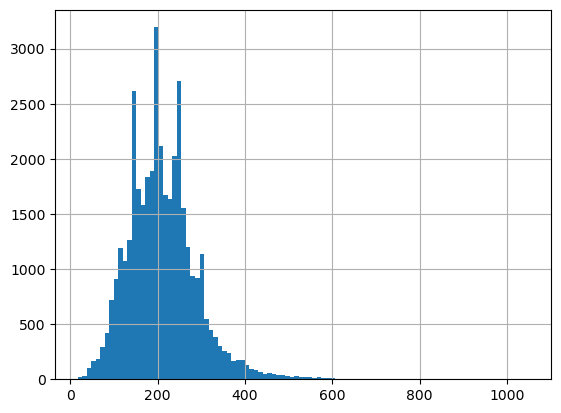

In [13]:
# checking to see the length of the documents
length_series = data_df["abstract_clean_light"].str.split().str.len()

print(length_series.describe())
length_series.hist(bins=100)

count    38686.000000
mean         0.651506
std          0.070664
min          0.319693
25%          0.604404
50%          0.648148
75%          0.695187
max          1.000000
Name: ttr, dtype: float64


<Axes: >

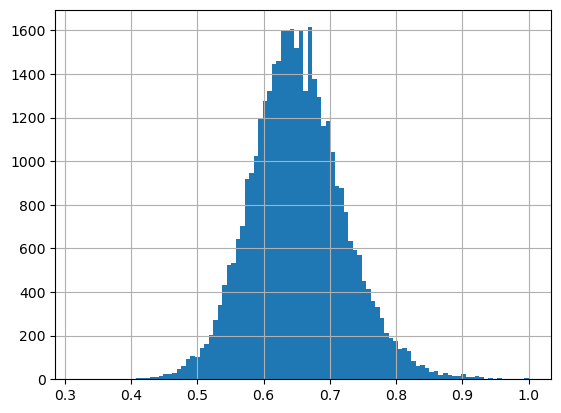

In [14]:
# type token ratio measure the diveristy in text (can help identify excessive repition)
def calc_ttr(text: str) -> float:
    words = text.split()
    unique_words = len(set(words))
    total_words = len(words)
    return unique_words / total_words if total_words > 0 else 0


# checking to see the length of the documents
data_df["ttr"] = data_df["abstract_clean_light"].apply(calc_ttr)

print(data_df["ttr"].describe())
data_df["ttr"].hist(bins=100)

In [15]:
data_df.query("ttr > 0.95").sample(5)

,doc_id,title,abstract,subject,abstract_clean_light,abstract_clean_heavy,target,ttr
3106,S0165176518304269,The effect of the Internet on economic sophist...,Backed by empirical results obtained from dyna...,soc_sci,Backed by empirical results obtained from dyna...,back empirical result obtain dynamic panel dat...,4,0.967742
11161,S0022314X19300307,On the asymptotics of a prime spin relation,"For certain cyclic totally real number fields,...",phys_sci,"For certain cyclic totally real number fields,...",certain cyclic totally real number field formu...,3,1.000000
24841,S0269749118343902,Mangrove forests as traps for marine litter,"Mangrove forests, through pneumatophores, are ...",phys_sci,"Mangrove forests, through pneumatophores, are ...",mangrove forest pneumatophore filter retain la...,3,0.952381
13406,S0269749118350176,Implications of using chemical dispersants to ...,This paper proposes a Bayesian network approac...,phys_sci,This paper proposes a Bayesian network approac...,paper propose bayesian network approach assess...,3,1.000000
6923,S1931312819302161,Preventing an Antigenically Disruptive Mutatio...,Wu et al. characterize the incompatibility bet...,healh_sci,Wu et al. characterize the incompatibility bet...,wu et al characterize incompatibility major eg...,1,0.960000


In [16]:
# removing empty strings
print("before:", data_df.shape[0])
data_df = data_df.loc[data_df["abstract_clean_light"].str.strip() != ""]
print("after:", data_df.shape[0])

before: 38686
after: 38686


## Splitting Data

In [17]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(
    data_df['abstract'], # note that we are starting by using raw data here
    data_df['target'],
    test_size=0.20,
    random_state=RANDOM_STATE
)

print(
    f"{X_train.shape=}",
    f"{X_test.shape=}",
    sep="\n"
)

X_train.shape=(30948,)
X_test.shape=(7738,)


## Vectorizer

In [18]:
# instantiate the vectorizer
vect = CountVectorizer()

# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3777725 stored elements and shape (30948, 107941)>

In [19]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 927904 stored elements and shape (7738, 107941)>

## Model Training

In [20]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [21]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: user 38.9 ms, sys: 9.12 ms, total: 48.1 ms
Wall time: 47.6 ms


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [22]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [23]:
# calculate precision and recall
print(
    classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
)


              precision    recall  f1-score   support

   engi_tech       0.68      0.84      0.75      1824
   healh_sci       0.76      0.77      0.76      1503
    life_sci       0.65      0.58      0.61      1153
    phys_sci       0.74      0.58      0.65      2590
     soc_sci       0.56      0.75      0.64       668

    accuracy                           0.69      7738
   macro avg       0.68      0.70      0.68      7738
weighted avg       0.70      0.69      0.69      7738



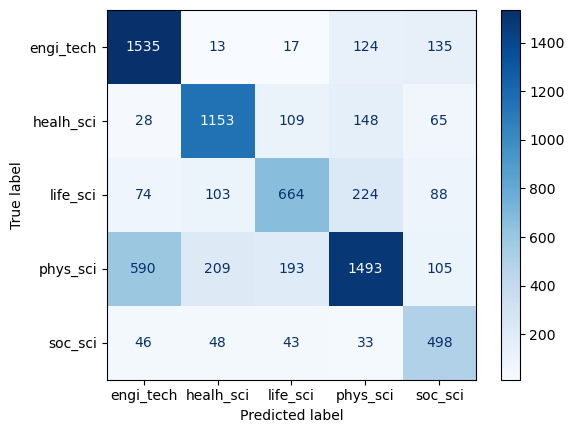

In [24]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_class,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)

In [25]:
feature_names = vect.get_feature_names_out()
probs = np.exp(nb.feature_log_prob_) # converting log probabilities to probabilities

In [26]:
# Number of top words to display per class
num_top_words = 10

# Iterate over each class
for class_label in nb.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(probs[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_probs = [probs[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {label_encoder.inverse_transform((class_label,))}:")
    for word, prob in zip(top_words, top_probs):
        print(f"{word}: {prob:.4f}")  # Convert log prob back to probability



Top words for ['engi_tech']:
the: 0.0636
of: 0.0390
and: 0.0313
to: 0.0225
in: 0.0201
for: 0.0114
is: 0.0112
with: 0.0086
that: 0.0072
on: 0.0067

Top words for ['healh_sci']:
the: 0.0389
and: 0.0355
of: 0.0350
in: 0.0249
to: 0.0197
with: 0.0123
for: 0.0103
were: 0.0082
was: 0.0075
is: 0.0059

Top words for ['life_sci']:
the: 0.0475
of: 0.0361
and: 0.0335
in: 0.0249
to: 0.0204
for: 0.0090
that: 0.0084
with: 0.0080
is: 0.0071
we: 0.0056

Top words for ['phys_sci']:
the: 0.0552
of: 0.0404
and: 0.0339
in: 0.0242
to: 0.0208
for: 0.0104
is: 0.0088
with: 0.0088
that: 0.0081
by: 0.0062

Top words for ['soc_sci']:
the: 0.0439
of: 0.0339
and: 0.0305
in: 0.0205
to: 0.0203
that: 0.0093
for: 0.0082
is: 0.0071
on: 0.0068
with: 0.0066


## Logistic Regression

In [27]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10_000)

In [28]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 7min 14s, sys: 2min 48s, total: 10min 2s
Wall time: 1min 24s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [29]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [30]:
# calculate precision and recall
print(
    classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
)

              precision    recall  f1-score   support

   engi_tech       0.73      0.75      0.74      1824
   healh_sci       0.76      0.74      0.75      1503
    life_sci       0.59      0.54      0.56      1153
    phys_sci       0.65      0.69      0.67      2590
     soc_sci       0.68      0.62      0.65       668

    accuracy                           0.68      7738
   macro avg       0.68      0.67      0.67      7738
weighted avg       0.68      0.68      0.68      7738



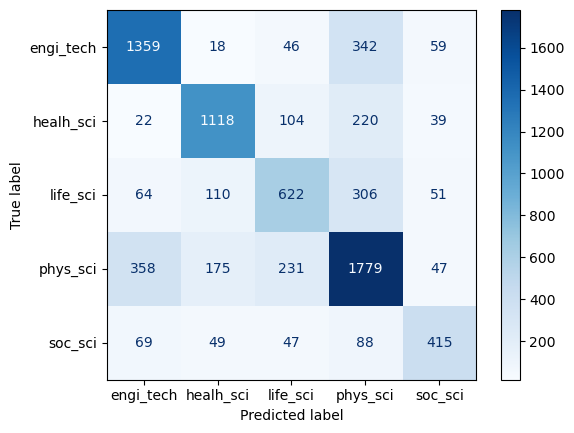

In [31]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_class,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)

#### Most important Features

In [32]:
feature_names = vect.get_feature_names_out()
weights = logreg.coef_

In [33]:
# Number of top words to display per class
num_top_words = 10

# Iterate over each class
for class_label in logreg.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(weights[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_weights = [weights[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {label_encoder.inverse_transform((class_label,))}:")
    for word, weight in zip(top_words, top_weights):
        print(f"{word}: {weight:.4f}")  # Convert log prob back to probability



Top words for ['engi_tech']:
enhancement: 0.8482
specifications: 0.8252
accidents: 0.7867
matlab: 0.7429
user: 0.7223
codes: 0.7141
engineering: 0.7119
tungsten: 0.7071
1960s: 0.6982
ensure: 0.6865

Top words for ['healh_sci']:
photoacoustic: 1.1674
conclusion: 1.0364
forensic: 0.9692
conclusions: 0.8270
surgical: 0.8239
infectious: 0.8039
failed: 0.7841
aimed: 0.7790
vaccines: 0.7430
optoacoustic: 0.7402

Top words for ['life_sci']:
firing: 0.9115
fmri: 0.7754
landsat: 0.7550
snhg16: 0.7271
neuroscience: 0.7215
neuroimaging: 0.7110
insects: 0.7002
tablet: 0.6932
perceptual: 0.6913
therapeutics: 0.6875

Top words for ['phys_sci']:
lhc: 0.8922
pku: 0.8278
inclusive: 0.8149
bioinformatics: 0.8020
disaster: 0.7964
pluripotent: 0.7949
vertex: 0.7774
2010: 0.7396
redox: 0.7038
ssps: 0.6801

Top words for ['soc_sci']:
archaeological: 1.1336
firms: 0.7256
panel: 0.6895
tourism: 0.6575
looking: 0.6478
problematic: 0.6328
phenomenon: 0.6272
contemporary: 0.6161
examines: 0.6069
financial: 0.60

## Improving model performance

In [34]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(
    data_df['abstract_clean_heavy'],
    data_df['target'],
    test_size=0.20,
    random_state=RANDOM_STATE
)

print(
    f"{X_train.shape=}",
    f"{X_test.shape=}",
    sep="\n"
)

X_train.shape=(30948,)
X_test.shape=(7738,)


In [35]:
# instantiate the vectorizer
vect = CountVectorizer(
    ngram_range=(1, 2)
)

# fit on training data
X_train_dtm = vect.fit_transform(X_train)

# apply to test data
X_test_dtm = vect.transform(X_test)

### Multinomial NB

In [36]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

# fitting model
nb.fit(X_train_dtm, y_train)

# predicting
y_pred_class = nb.predict(X_test_dtm)

In [37]:
# calculate precision and recall
print(
    classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
)


              precision    recall  f1-score   support

   engi_tech       0.72      0.86      0.78      1824
   healh_sci       0.70      0.82      0.76      1503
    life_sci       0.71      0.36      0.48      1153
    phys_sci       0.64      0.75      0.69      2590
     soc_sci       0.87      0.23      0.36       668

    accuracy                           0.69      7738
   macro avg       0.73      0.60      0.61      7738
weighted avg       0.70      0.69      0.66      7738



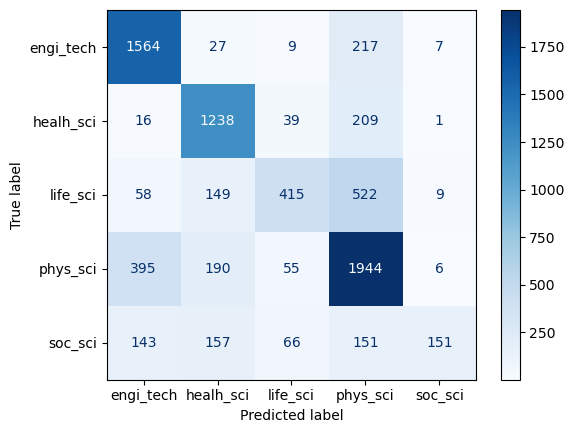

In [38]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_class,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)

In [39]:
feature_names = vect.get_feature_names_out()
probs = np.exp(nb.feature_log_prob_) # converting log probabilities to probabilities

In [40]:
# Number of top words to display per class
num_top_words = 10

# Iterate over each class
for class_label in nb.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(probs[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_probs = [probs[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {label_encoder.inverse_transform((class_label,))}:")
    for word, prob in zip(top_words, top_probs):
        print(f"{word}: {prob:.4f}")  # Convert log prob back to probability



Top words for ['engi_tech']:
model: 0.0016
energy: 0.0013
result: 0.0013
system: 0.0012
high: 0.0011
study: 0.0011
method: 0.0010
base: 0.0010
increase: 0.0008
datum: 0.0007

Top words for ['healh_sci']:
study: 0.0018
patient: 0.0018
year: 0.0011
result: 0.0011
high: 0.0010
group: 0.0010
age: 0.0009
disease: 0.0009
method: 0.0009
health: 0.0009

Top words for ['life_sci']:
study: 0.0012
result: 0.0008
high: 0.0008
increase: 0.0008
effect: 0.0008
model: 0.0007
cell: 0.0006
datum: 0.0006
specie: 0.0005
level: 0.0005

Top words for ['phys_sci']:
study: 0.0016
cell: 0.0015
model: 0.0013
result: 0.0013
high: 0.0012
method: 0.0010
datum: 0.0009
increase: 0.0009
base: 0.0008
effect: 0.0008

Top words for ['soc_sci']:
study: 0.0007
result: 0.0005
model: 0.0004
effect: 0.0004
paper: 0.0004
datum: 0.0004
social: 0.0004
research: 0.0003
high: 0.0003
health: 0.0003


### Logistic Regression

In [41]:
# instantiate a Multinomial Naive Bayes model
logreg = LogisticRegression(max_iter=10_000)

# fitting model
logreg.fit(X_train_dtm, y_train)

# predicting
y_pred_class = logreg.predict(X_test_dtm)

In [42]:
# calculate precision and recall
print(
    classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
)


              precision    recall  f1-score   support

   engi_tech       0.77      0.78      0.77      1824
   healh_sci       0.79      0.77      0.78      1503
    life_sci       0.65      0.57      0.61      1153
    phys_sci       0.70      0.74      0.72      2590
     soc_sci       0.69      0.66      0.67       668

    accuracy                           0.72      7738
   macro avg       0.72      0.70      0.71      7738
weighted avg       0.72      0.72      0.72      7738



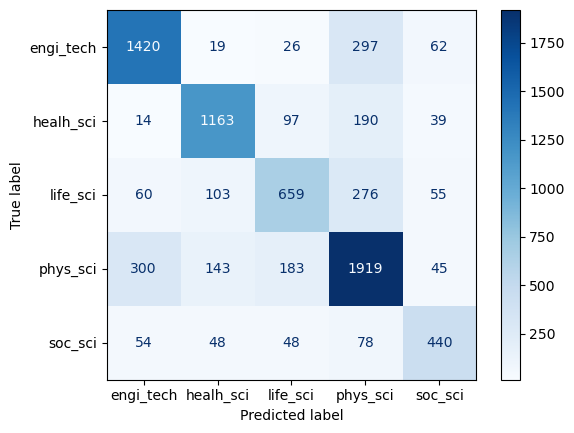

In [43]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_class,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)

In [44]:
feature_names = vect.get_feature_names_out()
weights = logreg.coef_

In [45]:
# Number of top words to display per class
num_top_words = 10

# Iterate over each class
for class_label in logreg.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(weights[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_weights = [weights[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {label_encoder.inverse_transform((class_label,))}:")
    for word, weight in zip(top_words, top_weights):
        print(f"{word}: {weight:.4f}")  # Convert log prob back to probability



Top words for ['engi_tech']:
code: 0.6867
software: 0.6132
fuel: 0.5949
user: 0.5806
alloy: 0.5688
accident: 0.5567
engineering: 0.5447
catalyst: 0.5431
enhancement: 0.5095
oa: 0.4857

Top words for ['healh_sci']:
conclusion: 1.0072
vaccine: 0.8828
surgical: 0.6606
parasite: 0.6604
objective: 0.6557
introduction: 0.6452
photoacoustic: 0.6425
immunization: 0.5606
forensic: 0.5582
tick: 0.5389

Top words for ['life_sci']:
tablet: 0.6207
fmri: 0.5344
conservation: 0.5097
formulation: 0.5057
habitat: 0.4951
ecosystem service: 0.4534
firing: 0.4481
plant: 0.4479
neuroscience: 0.4192
hippocampal: 0.4138

Top words for ['phys_sci']:
disaster: 0.5523
lhc: 0.5245
detector: 0.5235
decay: 0.4755
climate service: 0.4749
modification: 0.4743
rock: 0.4720
genomic: 0.4654
proteomic: 0.4445
pku: 0.4376

Top words for ['soc_sci']:
archaeological: 0.7357
firm: 0.6011
tourism: 0.5599
financial: 0.4706
century: 0.4687
intelligence: 0.4668
draw: 0.4638
economy: 0.4344
teacher: 0.4264
market: 0.4221


In [48]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=1.0)
clf.fit(X_train_dtm, y_train)

# predicting
y_pred_class = clf.predict(X_test_dtm)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [49]:
# calculate precision and recall
print(
    classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
)


              precision    recall  f1-score   support

   engi_tech       0.76      0.78      0.77      1824
   healh_sci       0.79      0.78      0.78      1503
    life_sci       0.65      0.59      0.62      1153
    phys_sci       0.70      0.74      0.72      2590
     soc_sci       0.71      0.66      0.68       668

    accuracy                           0.73      7738
   macro avg       0.72      0.71      0.72      7738
weighted avg       0.73      0.73      0.73      7738



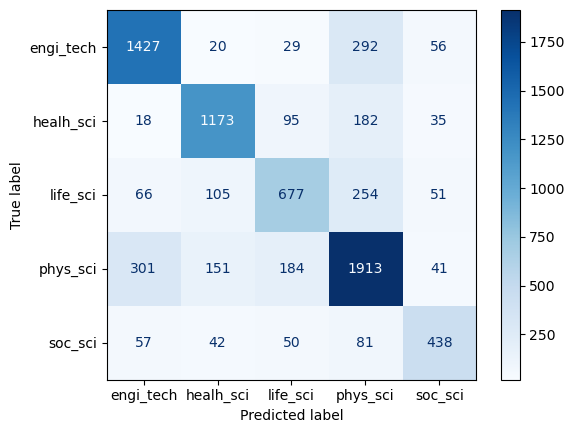

In [50]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_class,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)

In [51]:
feature_names = vect.get_feature_names_out()
weights = clf.coef_

In [52]:
# Number of top words to display per class
num_top_words = 10

# Iterate over each class
for class_label in clf.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(weights[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_weights = [weights[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {label_encoder.inverse_transform((class_label,))}:")
    for word, weight in zip(top_words, top_weights):
        print(f"{word}: {weight:.4f}")  # Convert log prob back to probability



Top words for ['engi_tech']:
code: 0.1938
matlab: 0.1795
software: 0.1528
enhancement: 0.1528
tungsten: 0.1528
comfort: 0.1420
biomaterial: 0.1414
energy policy: 0.1389
accident: 0.1376
user: 0.1328

Top words for ['healh_sci']:
photoacoustic: 0.2342
conclusion: 0.2164
surgical: 0.1831
vaccine: 0.1707
cholera: 0.1692
forensic: 0.1677
present case: 0.1650
immunization: 0.1602
protozoan: 0.1593
epidemic: 0.1558

Top words for ['life_sci']:
tablet: 0.1784
multiple level: 0.1753
firing: 0.1693
time integrate: 0.1556
connectome: 0.1549
mechanism safety: 0.1547
neuroscience: 0.1545
high time: 0.1531
integrate computational: 0.1526
understand drug: 0.1502

Top words for ['phys_sci']:
lhc: 0.1794
climate service: 0.1676
bioinformatics: 0.1632
disaster: 0.1576
colleague: 0.1551
substitute: 0.1536
pku: 0.1523
microplastic: 0.1455
macromolecular: 0.1442
proteomic: 0.1414

Top words for ['soc_sci']:
archaeological: 0.2479
tourism: 0.1725
interregional: 0.1581
century: 0.1326
financial: 0.1304
edu

### SGD

In [53]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(
    loss="hinge",       # SVM
    # loss="log_loss",  # logistic regression
    alpha=1e-5,
    max_iter=1000,
    n_jobs=-1
)
clf.fit(X_train_dtm, y_train)

,loss,'hinge'
,penalty,'l2'
,alpha,1e-05
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,-1


In [54]:
# calculate precision and recall
print(
    classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
)


              precision    recall  f1-score   support

   engi_tech       0.76      0.78      0.77      1824
   healh_sci       0.79      0.78      0.78      1503
    life_sci       0.65      0.59      0.62      1153
    phys_sci       0.70      0.74      0.72      2590
     soc_sci       0.71      0.66      0.68       668

    accuracy                           0.73      7738
   macro avg       0.72      0.71      0.72      7738
weighted avg       0.73      0.73      0.73      7738



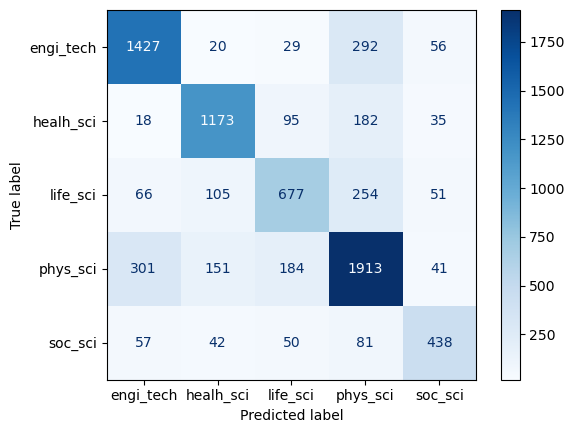

In [55]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_class,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)

In [56]:
feature_names = vect.get_feature_names_out()
weights = clf.coef_

In [57]:
# Number of top words to display per class
num_top_words = 10

# Iterate over each class
for class_label in clf.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(weights[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_weights = [weights[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {label_encoder.inverse_transform((class_label,))}:")
    for word, weight in zip(top_words, top_weights):
        print(f"{word}: {weight:.4f}")  # Convert log prob back to probability



Top words for ['engi_tech']:
accident: 5.9240
crash: 5.6037
fuel: 5.6037
code: 5.4436
safety: 5.2835
lpg: 5.1234
scaffold: 5.1234
engineering: 5.1234
rebound effect: 5.1234
stiffness: 4.9633

Top words for ['healh_sci']:
funding: 11.6599
conclusion: 11.4718
immunization: 9.9673
photoacoustic: 9.4031
parasite: 9.0270
introduction: 9.0270
surgical: 8.8389
vaccine: 8.8389
forensic: 8.6509
conclusions: 8.6509

Top words for ['life_sci']:
landsat: 8.2542
photosynthesis: 7.9173
ecosystem service: 7.7489
tablet: 7.0751
connectome: 7.0751
new method: 6.7382
fmri: 6.5697
bread: 6.4012
toxicant: 6.2328
nicotine: 6.2328

Top words for ['phys_sci']:
pku: 6.5552
radioactive: 6.4095
climate service: 5.9725
bioinformatics: 5.8268
fouling: 5.8268
lhc: 5.6812
cortisol: 5.5355
body weight: 5.5355
immune system: 5.3898
disaster: 5.3898

Top words for ['soc_sci']:
archaeological: 11.8480
holocene: 7.2910
constitute: 7.2910
intelligence: 7.0632
employment: 6.8354
financial: 6.8354
riparian: 6.6075
rural: 

### Trouble Shooting Result

In [58]:
pred_probas = logreg.predict_proba(X_test_dtm).round(3) # probabilities for each class

X_test_df = (
    X_test
    .to_frame()
    .assign( # adding actual and predicted labels
        actual_label=label_encoder.inverse_transform(y_test),
        predicted_label=label_encoder.inverse_transform(pred_probas.argmax(axis=1)),
    )
    .reset_index(drop=True)
)

pred_proba_df = pd.DataFrame(pred_probas, columns=label_encoder.classes_) # adding probabilities for each class
results_df = pd.concat([X_test_df, pred_proba_df], axis=1)

In [77]:
results_df.query("actual_label != predicted_label").sample(5)

,abstract_clean_heavy,actual_label,predicted_label,engi_tech,healh_sci,life_sci,phys_sci,soc_sci
6166,low adoption sustainable intensification techn...,life_sci,engi_tech,0.867,0.001,0.110,0.020,0.002
6507,extreme social cognitive deprivation result in...,life_sci,healh_sci,0.000,0.589,0.034,0.011,0.366
499,improved skill rural urban location labor gene...,life_sci,soc_sci,0.002,0.038,0.058,0.016,0.886
5188,understand success failure mass drug administr...,healh_sci,phys_sci,0.148,0.128,0.087,0.637,0.000
1322,identify current problem classroom conceptuali...,engi_tech,soc_sci,0.253,0.025,0.003,0.071,0.649


### TF-IDF

In [66]:
import sys

import spacy
import multiprocessing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import (
    CountVectorizer,
    HashingVectorizer,
    TfidfVectorizer,
)
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
)

RANDOM_STATE = 0
SPACY_MODEL = "en_core_web_md"

In [68]:
import pandas as pd

url = "https://storage.googleapis.com/adsp-nlp-open/data/elsevier-oa-cc-by/abstracts.json"
data = pd.read_json(url, orient="records")
data

,doc_id,title,abstract,subject
0,S0960076016300644,Sterols and oxysterols in plasma from Smith-Le...,Smith-Lemli-Opitz syndrome (SLOS) is a severe ...,phys_sci
1,S1471492219301369,The Uncertainty Surrounding the Burden of Post...,Post-acute consequences currently form a signi...,healh_sci
2,S2405580815000801,Low-mass molecular dynamics simulation for con...,"It has been reported recently that classical, ...",phys_sci
3,S0142961216305853,Modulation of the molecular arrangement in art...,The transfer of material from phospholipid-coa...,engi_tech
4,S0003682X1500242X,Validation of the blocked force method for var...,Vibro-acoustic source characterization is an e...,phys_sci
...,...,...,...,...
38681,S2212096317300165,Precipitation intensity-duration-frequency cur...,Engineering infrastructures such as stormwater...,phys_sci
38682,S0387760418301761,Everolimus for epilepsy and autism spectrum di...,Background: Epilepsy and autism spectrum disor...,healh_sci
38683,S0016718514000372,Strivers vs skivers: Class prejudice and the d...,This paper focuses on the moral dimension of e...,soc_sci
38684,S0040580915000878,Relationship inference from the genetic data o...,Relationship inference in a population is of i...,life_sci


In [70]:
import re

nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove non-alphabetic
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(tokens)

# Combine title + abstract
data['text'] = (data['title'] + " " + data['abstract']).apply(preprocess)

In [71]:
stop_words = nlp.Defaults.stop_words
len(stop_words)

326

In [72]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['subject'])

In [73]:
from sklearn.model_selection import train_test_split

X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [74]:
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3)
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(X_train_vec.shape)
print(X_test_vec.shape)

(30948, 10000)
(7738, 10000)


=== Multinomial NB ===
              precision    recall  f1-score   support

   engi_tech       0.71      0.83      0.76      1842
   healh_sci       0.73      0.77      0.75      1527
    life_sci       0.66      0.47      0.55      1130
    phys_sci       0.68      0.65      0.66      2610
     soc_sci       0.61      0.67      0.64       629

    accuracy                           0.69      7738
   macro avg       0.68      0.68      0.67      7738
weighted avg       0.69      0.69      0.69      7738

=== Logistic Regression ===
              precision    recall  f1-score   support

   engi_tech       0.77      0.78      0.78      1842
   healh_sci       0.77      0.79      0.78      1527
    life_sci       0.60      0.67      0.63      1130
    phys_sci       0.76      0.63      0.69      2610
     soc_sci       0.60      0.83      0.69       629

    accuracy                           0.72      7738
   macro avg       0.70      0.74      0.72      7738
weighted avg       0.73   

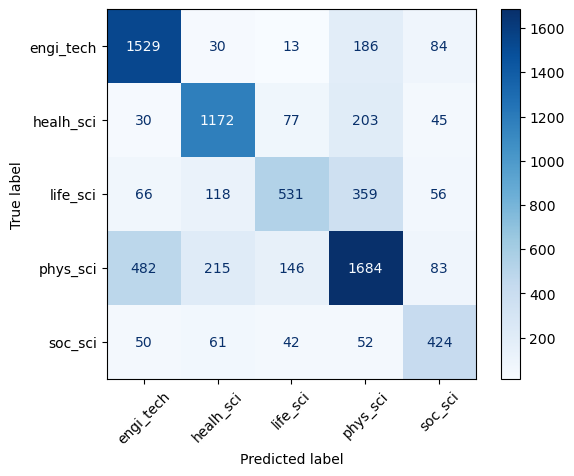

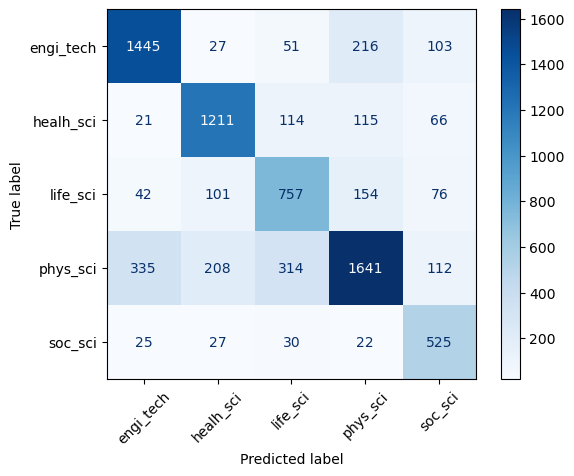

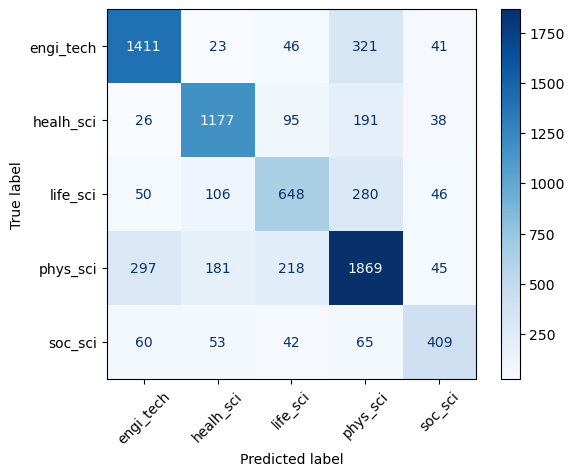

In [75]:
models = {
    "Multinomial NB": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Linear SVM": LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)

    y_pred = model.predict(X_test_vec)

    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=le.classes_, cmap="Blues", xticks_rotation=45
    )

    results[name] = y_pred


## What kind of models did you try and why?
*Models Used and Rationale*  
We experimented with Logistic Regression, Support Vector Machines (SVC), and Naive Bayes. These models are commonly used for text classification because they handle high-dimensional and sparse text features effectively. Logistic Regression and SVC are strong linear classifiers, while Naive Bayes provides a simple and efficient baseline for comparison.

These models were chosen because text data represented as bag-of-words or TF-IDF vectors tends to be sparse and high dimensional. Linear models such as Logistic Regression and SVC perform well in this setting, and Naive Bayes often achieves reasonable performance despite its strong independence assumptions.

## How did you evaluate the model and which metric do you think is most important? *Hint: Read the second paragraph introducing the assignment.*
*Model Evaluation and Metric*  

Models were evaluated using standard classification metrics, with F1 score as the primary metric. F1 was prioritized because it balances precision and recall, which is important when classes may be imbalanced and both false positives and false negatives matter.


## How did you investigate misclassifications?
*Investigation of Misclassifications&*    

Misclassifications were analyzed by examining feature weights to identify influential words for each class. Additionally, a sample of misclassified texts was manually reviewed to understand common error patterns.

## Were the misclassifications understandable (genuinely difficult examples) or were they blatant errors? Provide a few examples.
*Nature of Misclassifications*  


Most misclassifications were understandable and involved ambiguous or borderline examples where the correct label was not clear even to a human reader. For instance, abstracts involving mathematical or computational modeling (e.g., agricultural or geospatial modeling studies) were sometimes classified as Physical Sciences rather than Engineering & Technology, likely because they contained terminology commonly associated with physics. Similarly, some biomedical and life science articles (e.g., studies on brain development or disease interventions) were predicted as Health Sciences when disease- or treatment-related terms were especially prominent. A smaller number of errors were more clear-cut, as the predicted label did not reflect the main focus of the abstract, suggesting that the model placed too much emphasis on prominent keywords rather than the overall context.


In [82]:
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_columns', None)   
pd.set_option('display.width', 200)      
results_df.loc[[6166, 6507, 499, 5188, 1322],
              ['abstract_clean_heavy','actual_label','predicted_label']]

,abstract_clean_heavy,actual_label,predicted_label
6166,low adoption sustainable intensification technology hinder achievement potential impact increase agricultural productivity proper targeting location scale particular technology key determinant rate adoption targeting location similar biophysical socio economic characteristic significantly increase probability adoption area similar biophysical socio economic characteristic refer recommendation domain rd study geospatial analysis delineate sustainable recommendation domain srds scale improved crop variety good agronomic practice tanzania study use k means cluster identify relatively similar cluster grid raster represent biophysical socio economic environment critical ecosystem mask cluster generate srd potential impact scale technology generate srd assess spatial targeting index develop result identify 20 srd bio socio economic gradient delineate study propose impact based spatial targeting index ibsti objective tool priority set scale agricultural technology ibsti identify priority area srd target maximize potential impact scaling intervention data drive clustering method recommend region limited technology trial result demonstrate potential geospatial tool generate evidence base policy scaling sustainable intensification technology,life_sci,engi_tech
6507,extreme social cognitive deprivation result institutional care profound effect developmental outcome multiple domain abandon orphan child bucharest early intervention project beip examine outcome child originally place institution assess comprehensively randomize foster care fcg care usual caug follow longitudinally report brain electrical activity electroencephalogram eeg 12 year old child enrol beip previous report suggest improvement rest eeg activity group child place foster care intervention particularly place 24 month age compare child randomize caug place family age 12 year difference fcg caug persist alpha band 8 13 hz high frequency band i.e. beta band 15 30 hz child place fcg remain high quality care environment course study finding highlight importance maintain stable high quality caregive environment particularly child expose early psychosocial deprivation promote healthy brain development,life_sci,healh_sci
499,improved skill rural urban location labor generally implicit ignore food security projection analyze alternative labor supply assumption contrast scenario change skill level urbanization reverse decrease food price improve instead worsen country income inequality slow decrease number people 2500 calorie day available increase environmental impact agriculture urbanization observe net income benefit high food price poor long hold future explicitly address demographic change key projection guide policymaker address unequal impact food security combat climate change promote sustainable food production,life_sci,soc_sci
5188,understand success failure mass drug administration campaign critically depend level coverage achieve end coverage level closely scrutinise campaign response underperform campaign attempt improve coverage modelling work indicate quality coverage achieve significant impact outcome coverage achieve likely miss similar people round detrimental effect campaign outcome begin review current modelling description effect introduce new modelling framework simulate give level systematic non adherence formalise likelihood people miss round treatment correlation attendance different round simplified model infection helminth non helminth respectively demonstrate modelling description correlation include treatment round profound effect time elimination disease population clear detailed coverage datum require accurately predict time disease elimination review publish coverage datum individual ask previous round attend information assess level systematic non adherence note coverage datum find range 40.5 95.5 correlation find lie fairly narrow range 0.2806 0.5351 indicate level systematic non adherence 